<a href="https://colab.research.google.com/github/Nastaranrad/Plaque-comonent-identification/blob/main/DNN_Plaque.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import needed packages and libraries

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 24 10:53:19 2022

@author: nastaran
"""

import numpy as np
from numpy.random import seed
seed(1)
import tensorflow
from tensorflow.random import set_seed
tensorflow.random.set_seed(2)
import random as python_random
python_random.seed(123)
import scipy.io as sio
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, Conv1D, BatchNormalization, MaxPooling1D, AveragePooling1D
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.models import model_from_json
from tensorflow.keras import backend as K
from tensorflow.keras import Input
import seaborn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score, accuracy_score, auc, roc_curve, roc_auc_score, recall_score, precision_score, matthews_corrcoef, confusion_matrix
import os 
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Lambda
from tensorflow.keras import Model
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import matplotlib.patches as patches
from tensorflow.keras import backend as K
from tensorflow.keras import utils
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

### Preprocessing: using different normalization methods

In [10]:

def standard_standardization2D_data(x_train, x_test3, x_test4):
    """
    

    Parameters
    ----------
    x_train : TYPE
        DESCRIPTION.
    x_test3 : Plaque: 2D array
        DESCRIPTION.
    x_test4 : plaque: 2D array n*102
        DESCRIPTION.

    Returns
    -------
    x_train : TYPE
        normalized training data.
    x_test3 : TYPE
        normalized test data.
    x_test4 : TYPE
        normalized test data.
    scaler : TYPE
        DESCRIPTION.

    """

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test3 = scaler.transform(x_test3)
    x_test4 = scaler.transform(x_test4)

    return x_train, x_test3, x_test4, scaler
    
#%%
def minmax_standardization (x_train, x_test3, x_test4):

    """
    Parameters
    ----------
    x_train : TYPE
        training data.
    x_test3 : TYPE
        test data (plaque).
    x_test4 : TYPE
        test data (plaque).

    Returns
    -------
    x_train : TYPE
        normalized training data.
    x_test3 : TYPE
        normalized test data.
    x_test4 : TYPE
        normalized test data.      
    scaler : TYPE
        DESCRIPTION.

    """

    scaler = MinMaxScaler(feature_range = (-1,1))
    # scaler = MinMaxScaler(feature_range = (0,1))
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test3 = scaler.transform(x_test3)    
    x_test4 = scaler.transform(x_test4)    

    return x_train, x_test3, x_test4, scaler

#%%

def robust_minmax(array): ## array: predictions
    
    shape = list(array.shape[:-1])
    last_dim = len(array.shape) - 1 
    
    array = np.reshape(array,[np.prod(array.shape[0:last_dim]), array.shape[last_dim]])
    
    min_array = np.zeros(array.shape[0])
    max_array = np.zeros(array.shape[0])
    
    n = int(np.round(array.shape[1] / 10))
    
    idx = array.argsort(axis=1)[:,-n:]
    for i in range(array.shape[0]):
        max_array[i] = np.median(array[i, idx[i,:]])
        
    idx = array.argsort(axis=1)[:,0:n]
    for i in range(array.shape[0]):
        min_array[i] = np.median(array[i, idx[i,:]])
    
    max_array = np.reshape(max_array, shape+[1])
    min_array = np.reshape(min_array, shape+[1])
    minmax = np.concatenate((min_array, max_array), axis=last_dim)

    return minmax

### Set the parameters for training CNN

In [11]:
### parameters for training CNN

def set_params(num_materials = 5):    
    """
    

    Parameters
    ----------
    nm_materials : int32
        DESCRIPTION. The default is 4.
        specify the number of materials in the input data
        4: collagen, cholesterol, blood, water
        3: for any material above that does not exist in the data

    Returns
    -------
    dict_ : dictionary
        network parameters set with the different values.

    """
    
    dict_ = {
            'nb_classes':num_materials, 
            'neuron_num':[16, num_materials],  
            'normalization':0,
            #'runNum':5,
            'nb_filters':[32],
            'kernel_size':[10],
            'pool_size':2 , 
            'stride_size':2 ,
            'padding':'same',
            'nb_epoch':[100],
            'learn_rate': 3e-4, 
            'batch_size':32, 
            'dropout_level': 0.1,
            'activation': 'relu',
            # 'kernel_initializer':'he_normal',
            'kernel_initializer':'random_normal',
            #'kernel_initializer':tensorflow.keras.initializers.RandomUniform(minval=0., maxval=1.),
            # 'kernel_initializer':tensorflow.keras.initializers.GlorotNormal(),
            #'kernel_initializer':tensorflow.keras.initializers.GlorotUniform(),            
            'epsilon': 1e-6, 
            'momentum':0.9, 
            'weights' : None,
            'training' : True,
            'loss': 'categorical_crossentropy',

    }
       
    return dict_



### Getting Started : Setting up the google drive
Go to the link: https://drive.google.com/drive/folders/1TGTFrBlo1nj_tV6WvOZu-RYCnfGXdJby?usp=sharing and click on add the shortcut to my drive. This will add the shortcut to My Drive.

In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Read data and change the labels from 1-5 to 0-4

In [13]:
#%%

dataPath = r"/content/drive/MyDrive/PA_data/" # path where training data and labels are stored
savePath = r"/content/drive/MyDrive/PA_data/Results/"
#dataPath = 'path to data'
#savePath = 'path for saving results'

### read data (the absolute value of data and convert it to float32) 
matContent = sio.loadmat(dataPath + 'DLdataset.mat')
data = np.float32(np.abs(matContent['PlaqueEM']))
labels = matContent['PlaqueMat']

### change the range of labels from 1-5 to 0-4
##  1 collagen, 2 blood, 3 Lipid, 4 SMC, 5 Background
labels[labels==1]=0  ## collagen
labels[labels==2]=1  ## blood
labels[labels==3]=2  ## lipid
labels[labels==4]=3  ## SMC
labels[labels==5]=4  ## Background

### Read test data and size, compute the data log, random permutation of training data, and normalize data

In [14]:
## 1. reading test data and save the size of each test data to be used later in the prediction phase 
test_data = []
matContent = sio.loadmat(dataPath + 'TestDL_Data2.mat')
testData3 = np.float32(np.abs(matContent['Patient19_2']))
testData4 = np.float32(np.abs(matContent['Patient2015']))

plaque_size = [[testData3.shape[0],testData3.shape[1]],
               [testData4.shape[0],testData4.shape[1]]]

### 2. compute the log of data, reshape data to a 2D matrix, and do the data normalization
data = np.log(data)
testData3 = np.log(testData3)
testData4 = np.log(testData4)

### 3. random permutation of trainingData
indx = np.random.permutation(data.shape[0])
data = data[indx,:]
labels = labels[indx,]

testData3 = np.reshape(testData3,[testData3.shape[0]*testData3.shape[1],testData3.shape[2]])
testData4 = np.reshape(testData4,[testData4.shape[0]*testData4.shape[1],testData4.shape[2]])

normalization_type = 'standard_standardization'
if normalization_type == 'standard_standardization':
      trainingFeatures, testFeatures3, testFeatures4, scaler = standard_standardization2D_data(data, testData3, testData4)

elif normalization_type == 'minmax_standardization':
    trainingFeatures, testFeatures3, testFeatures4, scaler = minmax_standardization(data, testData3, testData4)
    


### 4. adding one axis to the trainingFeatures and testFeatures, and making the labels in 5 categories
trainingFeatures = trainingFeatures[...,np.newaxis] 
testFeatures3 = testFeatures3[...,np.newaxis]  
testFeatures4 = testFeatures4[...,np.newaxis]  

test_data.append(testFeatures3) 
test_data.append(testFeatures4) 



### convert the labels to a categorical form
### define lists to keep the median, mean, max, and min of predictions over 100 iterations
### weight the classes to balance data


In [15]:
### 5. set the number of classes and make the labels to a categorical form  
list_params = set_params(num_materials = 5)
trainingLabels1 = utils.to_categorical(np.squeeze(labels), list_params['nb_classes'])

runNum = 2
iteration = 100

header_count = len(test_data) + 1
list_mean_predictions = [[]for i in range(1, header_count)]
list_median_predictions = [[]for i in range(1, header_count)]
list_min_predictions = [[]for i in range(1, header_count)]
list_max_predictions = [[]for i in range(1, header_count)]

weights_ = compute_class_weight("balanced", classes = np.unique(labels), y = np.squeeze(labels))
class_weights = {0:weights_[0],
                1: weights_[1],
                2: weights_[2],
                3: weights_[3],
                4: weights_[4]}
fileName = ['Patient19_2','Patient2015']

j = 0


### construct network architecture, compile, and make predictions

In [16]:
random_seed = [1000,2000,3000]
for run in range(runNum):
    seed(random_seed[run])
    set_seed(random_seed[run])
    print ('Run:' , run+1)
    ### 6. Network construction
    inputs = Input(shape=(trainingFeatures.shape[1],trainingFeatures.shape[2]))
    x = Conv1D(filters=list_params["nb_filters"][0], kernel_size= list_params["kernel_size"][0], padding = list_params["padding"], kernel_initializer=list_params["kernel_initializer"])(inputs)
    x = MaxPooling1D(pool_size = list_params["pool_size"], strides = list_params["stride_size"], padding=list_params["padding"])(x)
    x = Activation(list_params["activation"])(x)
    x = Flatten()(x)
    x = BatchNormalization(epsilon=list_params["epsilon"], momentum = list_params["momentum"], weights = list_params["weights"])(x)
    x = Dropout(list_params["dropout_level"])(x, training = list_params["training"])
    x = Dense(list_params["neuron_num"][0], kernel_initializer = list_params['kernel_initializer'], activation = list_params['activation'])(x)
    x = Dropout(list_params["dropout_level"])(x, training=list_params["training"])
    x = Dense(list_params["neuron_num"][1], kernel_initializer = list_params['kernel_initializer'])(x)
    output = Activation('softmax')(x)
    
    model = Model(inputs, output)
    model.summary()
    optimizer = Adam(list_params["learn_rate"])
    model.compile(loss=list_params["loss"], optimizer = optimizer, metrics=['accuracy'])
    model.fit(trainingFeatures, trainingLabels1, batch_size = list_params["batch_size"], epochs = list_params["nb_epoch"][0],
              verbose=2, validation_split=0.0, shuffle=False, class_weight=class_weights) #callbacks=[earlyStopping], 
    
    ### 7. save learned features  ################3  
    get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[3].output,]) 
    layer_output_training = get_3rd_layer_output([trainingFeatures])[0] 
    layer_output_test3 = get_3rd_layer_output([test_data[0]])[0]
    layer_output_test4 = get_3rd_layer_output([test_data[1]])[0]

    #target_names = ['Collagen', 'Blood', 'Lipid', 'SMC', 'Background'] ## to specify the labels for classification report
    
    ### 8. save the trained model and weights
    json_string = model.to_json()
    open(savePath + 'CNN' + '_run_' + str(run+1) + '.json', 'w').write(json_string)       
    model.save_weights(savePath + 'CNN' + '_run_' + str(run+1) + '.h5', overwrite=True)  

############################################    
    ### 9. Compute the mean, median, max, and min over all predictions
    for i in range(len(test_data)): 
        ## 9.1 reserve a list for appending all predictions (iterations) in one run 
        list_predictions = [] 
        ## 9.2 predict on each test data, reshaped data, add a new axis 
        ## to predictions, append them, concatenate them via the added new axis to make the mean, etc
        for r in range(iteration):
            soft_targets = model.predict(test_data[i],verbose = 0)
            reshaped_prediction = np.reshape(soft_targets,[plaque_size[i][0], plaque_size[i][1],list_params["nb_classes"]])
            reshaped_prediction = reshaped_prediction[...,np.newaxis]
            list_predictions.append(reshaped_prediction)            
        concatenated_predictions = np.concatenate(list_predictions, axis = 3)
        ### makeing the robust min max of the predictions
        minmax_ = robust_minmax(concatenated_predictions)
        list_min_predictions[i].append(minmax_[:,:,:,0])
        list_max_predictions[i].append(minmax_[:,:,:,1])
    
        ## 9.3 for each test data and one run compute the mean, median, max, and min over all iterations
        list_mean_predictions[i].append(np.mean(concatenated_predictions, axis = 3))
        median_ = np.median(concatenated_predictions, axis = 3)
        median_ = median_/np.expand_dims(np.sum(median_, axis=2), axis=2)
        list_median_predictions[i].append(median_)
        
        ## 10. Save the computed mean, median, max, and min over predictions (iterations) in each run
        sio.savemat(savePath + 'Results_for_computingUncertainty_' + fileName[i] + 'run_' + str(run+1) + '.mat',
            {'mean_predictions':list_mean_predictions[i][run],
            'median_predictions':list_median_predictions[i][run],'max_predictions':list_max_predictions[i][run],'min_predictions':list_min_predictions[i][run]})
    


Run: 1
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 102, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 102, 32)           352       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 51, 32)           0         
 1D)                                                             
                                                                 
 activation_4 (Activation)   (None, 51, 32)            0         
                                                                 
 flatten_2 (Flatten)         (None, 1632)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 1632)             6528      
 hNormalization)                                    

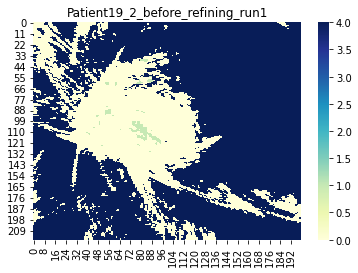

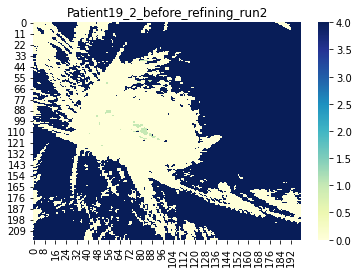

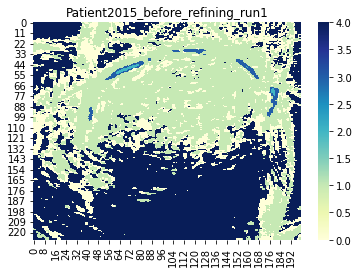

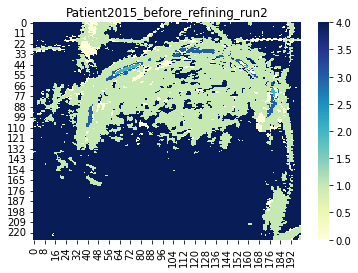

In [17]:
#### 11. Plot the results 
for i in range(len(fileName)):
    for run in range(runNum):        
        plt.figure()
        seaborn.heatmap(np.argmax(list_median_predictions[i][run], axis=2), cmap="YlGnBu")
        plt.title(fileName[i] + '_before_refining_run' + str(run+1))    
        plt.savefig(savePath + '/' + fileName[i] + '_before_refining_run'+str(run+1) + '.png')
